In [1]:
import sklearn
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from statistics import median, mean
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import RocCurveDisplay

In [2]:
dir = "data/"

employee_survey = pd.read_csv(dir + "employee_survey_data.csv")
general = pd.read_csv(dir + "general_data.csv")
manager_survey = pd.read_csv(dir + "manager_survey_data.csv")
in_time = pd.read_csv(dir + "in_time.csv")
out_time = pd.read_csv(dir + "out_time.csv")

In [3]:
np.random.seed(4444)

# Sommaire

<ul>
    <li><a href="#es">Employe survey</a></li>
    <li><a href="#ge">General</a></li>
    <li><a href="#ms">Manager survey</a></li>
    <li><a href="#it">In Time</a></li>
    <li><a href="#ot">Out Time</a></li>
    <li><a href="#ld">Lien entre les dataset</a></li>
    <li><a href="#cc">Conclusion</a></li>
</ul>

# Définition des variables globales

In [4]:
nbEmploye = employee_survey["EmployeeID"].max()
print("Il y a", nbEmploye, "employés dans le dataset")

Il y a 4410 employés dans le dataset


# Employee survey
<div id="es"></div>

## Données contenues dans le set

In [5]:
employee_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


## Anaylse des données vides

In [6]:
employee_survey.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

## Répartition des notes

<Axes: >

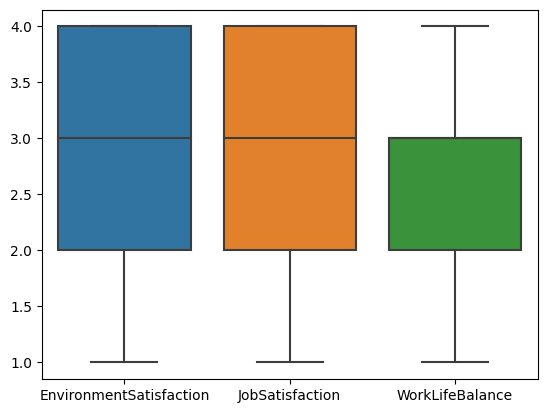

In [7]:
employee_survey_anonyme = employee_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=employee_survey_anonyme)


<Axes: ylabel='Count'>

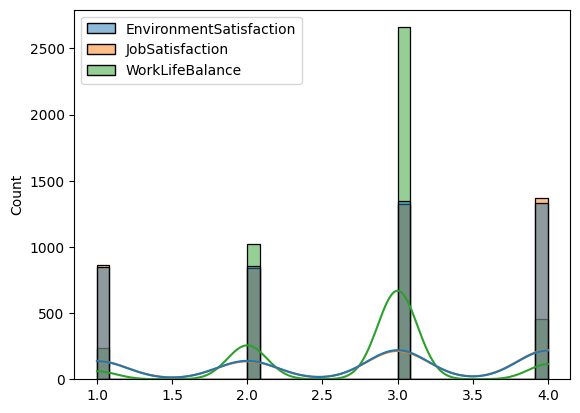

In [8]:
sns.histplot(data=employee_survey_anonyme, kde=True)

## Tendance des mauvais résultats

On regarde tout d'abord le nombre de gens qui sont insatisfait le l'environnement de travail et on remarque qu'ils représentent 38,5% des employés

In [9]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1].count()
print(BadEnvironmentSatisfaction['EnvironmentSatisfaction'] / nbEmploye * 100)
BadEnvironmentSatisfaction


38.57142857142858


EmployeeID                 1701
EnvironmentSatisfaction    1701
JobSatisfaction            1694
WorkLifeBalance            1685
dtype: int64

On fait la même chose pour la satisfaction sur leurs travail et on obtient des résultats similaires, ce qui confirme les boîtes a moustache

In [10]:
BadJobSatisfaction = employee_survey[employee_survey['JobSatisfaction']<2.1].count()
print(BadJobSatisfaction['JobSatisfaction'] / nbEmploye * 100)
BadJobSatisfaction

38.54875283446712


EmployeeID                 1700
EnvironmentSatisfaction    1694
JobSatisfaction            1700
WorkLifeBalance            1687
dtype: int64

Enfin on regarde l'équilibre entre la vie privée et professionelle, dans ce cas on obtient 28.5% des employés

In [11]:
BadWorkLifeBalance = employee_survey[employee_survey['WorkLifeBalance']<2.1].count()
print(BadWorkLifeBalance['WorkLifeBalance'] / nbEmploye * 100)
BadWorkLifeBalance

28.52607709750567


EmployeeID                 1258
EnvironmentSatisfaction    1250
JobSatisfaction            1254
WorkLifeBalance            1258
dtype: int64

Si on essaie de regarder les employés qui ont a la foie une balance mauvaise, et une satisfaction de leur travail et de leur environnement de travail faible on obtient 178 personne avec une très mauvaise expérience

In [12]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1]
BadSatisfaction = BadEnvironmentSatisfaction[BadEnvironmentSatisfaction['JobSatisfaction']<2.1]
BadAll = BadSatisfaction[BadSatisfaction['WorkLifeBalance']<2.1]
BadAll["EmployeeID"].count()

178

# General
<div id="ge"></div>

## Données contenue dans le set

In [13]:
general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


## Analyse des données vides

In [14]:
general.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

## Modifications nécéssaires

### Variables discrètes hierarchiques

Ensuite, on remplace les valeurs dans "BusinessTravel" avec l'"OrdinalEncoder" car il y a un ordre hiérarchique entre les données

In [15]:
ord_enc = OrdinalEncoder(categories=[['Non-Travel','Travel_Rarely','Travel_Frequently']])
encoded = ord_enc.fit_transform(general[["BusinessTravel"]])
general.drop('BusinessTravel', axis=1)
general = general.assign(BusinessTravel = encoded) 

In [16]:
ord_enc = OrdinalEncoder(categories=[['No','Yes']])
encoded = ord_enc.fit_transform(general[["Attrition"]])
general.drop('Attrition', axis=1)
general = general.assign(Attrition = encoded) 

In [17]:
ord_enc = OrdinalEncoder(categories=[['N','Y']])
encoded = ord_enc.fit_transform(general[["Over18"]])
general.drop('Over18', axis=1)
general = general.assign(Over18 = encoded) 

### Variables discrètes indépendantes
Ensuite on remplace les valeurs dans "Department" avec le "OneHotEncoder" car il n'y a pas de hiérarchie entre les valeurs

In [18]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Department']])
dpt_enc = pd.DataFrame(encoded.toarray())
dpt_enc = dpt_enc.rename(columns={0:'Department_HR', 1:'Department_Research & Development', 2:'Department_Sales'})
general.drop('Department', axis=1, inplace=True)
general = pd.concat([general, dpt_enc], axis=1)

In [19]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['EducationField']])
edu_enc = pd.DataFrame(encoded.toarray())
edu_enc = edu_enc.rename(columns={
    0:'Education_Human Resources', 
    1:'Education_Life Sciences', 
    2:'Education_Marketing', 
    3:'Education_Medical', 
    4:'Education_Other', 
    5:'Education_Technical Degreee'})
general.drop('EducationField', axis=1, inplace=True)
general = pd.concat([general, edu_enc], axis=1)

In [20]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Gender']])
gen_enc = pd.DataFrame(encoded.toarray())
gen_enc = gen_enc.rename(columns={0:'Female', 1:'Male'})
general.drop('Gender', axis=1, inplace=True)
general = pd.concat([general, gen_enc], axis=1)


In [21]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['JobRole']])
job_enc = pd.DataFrame(encoded.toarray())
job_enc = job_enc.rename(columns={
    0:'Job_Healthcare Representative', 
    1:'Job_Human Resources', 
    2:'Job_Laboratory Technician', 
    3:'Job_Manager', 
    4:'Job_Manufacturing Director',
    5:'Job_Research Director',
    6:'Job_Research Scientist',
    7:'Job_Sales Executive',
    8:'Job_Sales Representative'})
general.drop('JobRole', axis=1, inplace=True)
general = pd.concat([general, job_enc], axis=1)

In [22]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['MaritalStatus']])
mar_enc = pd.DataFrame(encoded.toarray())
mar_enc = mar_enc.rename(columns={0:'Divorced', 1:'Married', 2:'Single'})
general.drop('MaritalStatus', axis=1, inplace=True)
general = pd.concat([general, mar_enc], axis=1)

La classe globale encoder fait strictement la même chose que les cellules précédentes a ceci près qu'elle peu être intégré au pipeline

In [23]:
class global_encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, data):
        bus_enc = self.ordinal_encode(data['BusinessTravel'])
        data.drop(["BusinessTravel"], axis=1, inplace=True)
        att_enc = self.ordinal_encode(data['Attrition'])
        data.drop(["Attrition"], axis=1, inplace=True)
        ove_enc = self.ordinal_encode(data['Over18'])
        data.drop(["Over18"], axis=1, inplace=True)

        mar_enc = self.one_hot_encode(data['MaritalStatus'])
        data.drop(["MaritalStatus"], axis=1, inplace=True)
        dep_enc = self.one_hot_encode(data['Department'])
        data.drop(["Department"], axis=1, inplace=True)
        edu_enc = self.one_hot_encode(data['EducationField'])
        data.drop(["EducationField"], axis=1, inplace=True)
        job_enc = self.one_hot_encode(data['JobRole'])
        data.drop(["JobRole"], axis=1, inplace=True)
        gen_enc = self.one_hot_encode(data['Gender'])
        data.drop(["Gender"], axis=1, inplace=True)

        return pd.concat([data, mar_enc, bus_enc, att_enc, ove_enc, dep_enc, edu_enc, job_enc, gen_enc], axis=1)


    def one_hot_encode(self, column):
        one_enc = OneHotEncoder()
        encoded = one_enc.fit_transform(column)
        df_enc = pd.DataFrame(encoded.toarray())
        return df_enc.rename(columns=column.unique())
    
    def ordinal_encode(self, column):
        ord_enc = OrdinalEncoder(categories=column.unique())
        encoded = ord_enc.fit_transform(column)
        return pd.DataFrame(encoded.toarray())
        


In [24]:
general

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,...,Job_Laboratory Technician,Job_Manager,Job_Manufacturing Director,Job_Research Director,Job_Research Scientist,Job_Sales Executive,Job_Sales Representative,Divorced,Married,Single
0,51,0.0,1.0,6,2,1,1,1,131160,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,31,1.0,2.0,10,1,1,2,1,41890,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,32,0.0,2.0,17,4,1,3,4,193280,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,38,0.0,0.0,2,5,1,4,3,83210,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32,0.0,1.0,10,1,1,5,1,23420,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0.0,1.0,5,4,1,4406,1,60290,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4406,29,0.0,1.0,2,4,1,4407,1,26790,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,25,0.0,1.0,25,2,1,4408,2,37020,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4408,42,0.0,1.0,18,2,1,4409,1,23980,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Analyse générales

### Nombres de personnes qui ont quitté l'entreprise en 2016

In [25]:
peopleLeft = general[general["Attrition"] == 1]
print("Number of people who left the company:", peopleLeft.shape[0], "out of", general.shape[0], "employees")
print("Approx", round(peopleLeft.shape[0] / general.shape[0] * 100, 2), "% of the employees left the company")

Number of people who left the company: 711 out of 4410 employees
Approx 16.12 % of the employees left the company


### Heatmap

Grâce a cette HeatMap on remarque qu'il n'y a pas de réel corrélation significative entre les gens qui s'en vont et leurs situations

<Axes: >

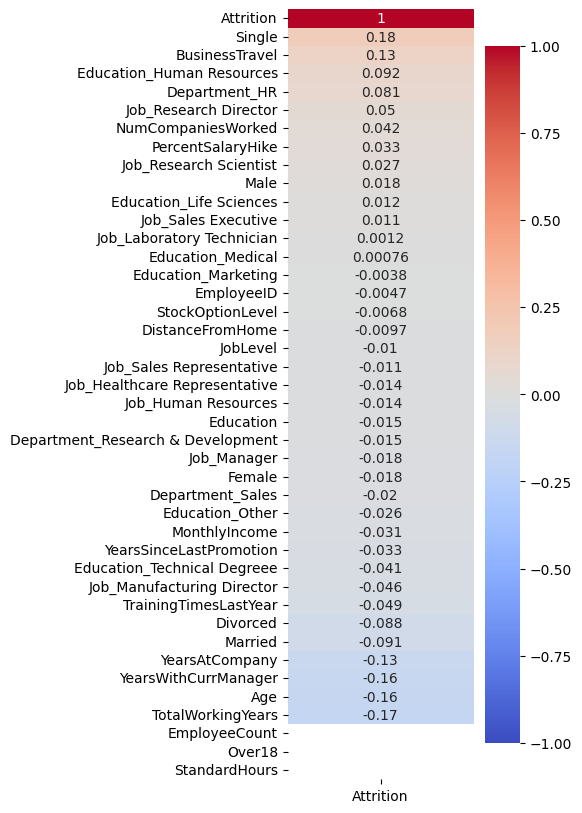

In [26]:
plt.figure(figsize=(3, 10))
general_corr = general.corr()
sns.heatmap(general_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

### Histogrammes

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'Education'}>],
       [<Axes: title={'center': 'JobLevel'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>],
       [<Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'center': 'TrainingTimesLastYear'}>],
       [<Axes: title={'center': 'YearsAtCompany'}>,
        <Axes: title={'center': 'YearsSinceLastPromotion'}>,
        <Axes: title={'center': 'YearsWithCurrManager'}>]], dtype=object)

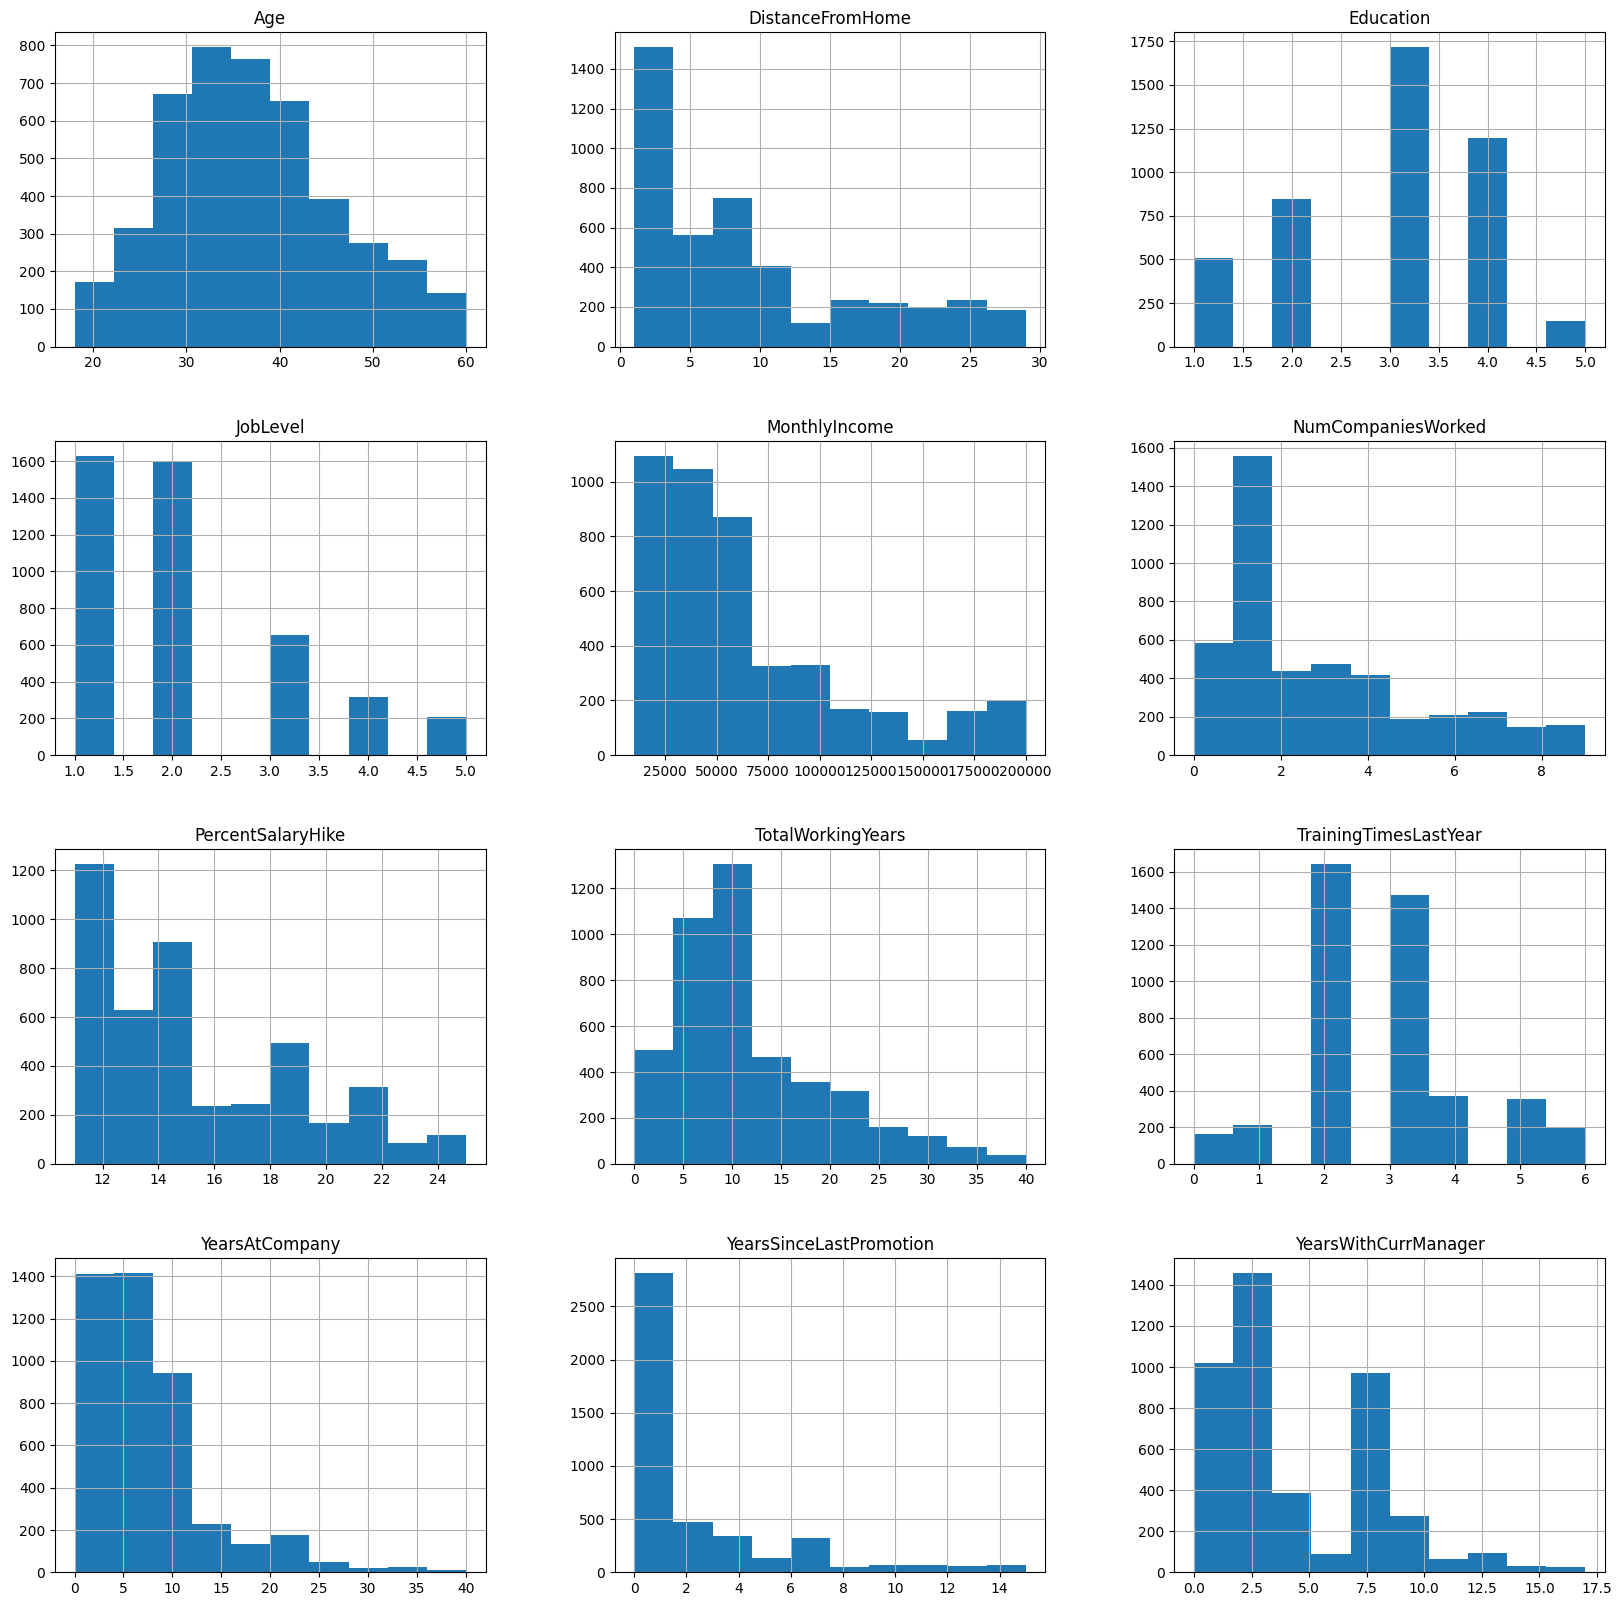

In [27]:
general.filter(items= ["Age","DistanceFromHome","Education","JobLevel", "MonthlyIncome", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]).hist(figsize=(20,20))

# Manager survey
<div id="ms"></div>

## Données contenue dans le set

In [28]:
manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


## Analyse des données vides

In [29]:
manager_survey.isnull().sum()

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

## Analyse générale

<Axes: >

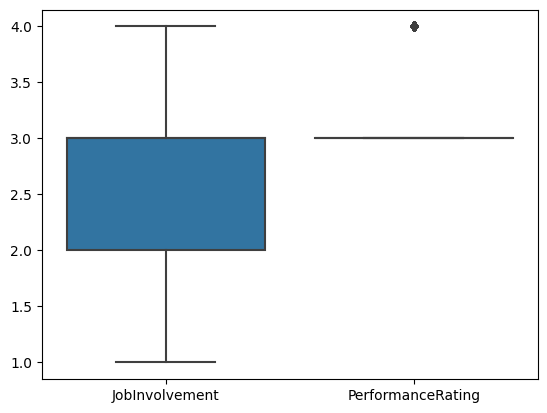

In [30]:
manager_survey_anonyme = manager_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=manager_survey_anonyme)

#corréler avec attrition

# In Time
<div id="it"></div>

## Données contenues dans le dataset

In [31]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


## Analyse des données vides

In [32]:
print("Par date")
print(in_time.isnull().sum())
print("Par employé")
print(in_time.isnull().sum(axis=1))

Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


## Répartition des données

<Axes: >

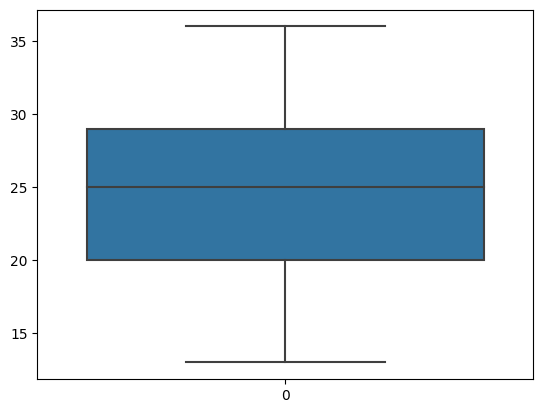

In [33]:

sns.boxplot(in_time.isnull().sum(axis=1))

# Out Time
<div id="ot"></div>

## Données contenues dans le set

In [34]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


## Analyse des données vides

In [35]:
print("Par date")
print(out_time.isnull().sum())
print("Par employé")
print(out_time.isnull().sum(axis=1))


Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


## Répartition des données

<Axes: >

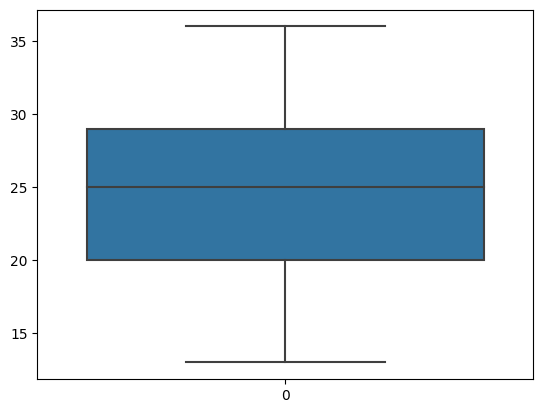

In [36]:

sns.boxplot(in_time.isnull().sum(axis=1))

# Lien entre des datasets
<div id="ld"></div>

## Données générales

### Base du temps

In [37]:
dayOff = in_time.isnull().sum() == 4410
print("Il y a", dayOff.sum() ,"jours de congés" )

Il y a 12 jours de congés


<Axes: >

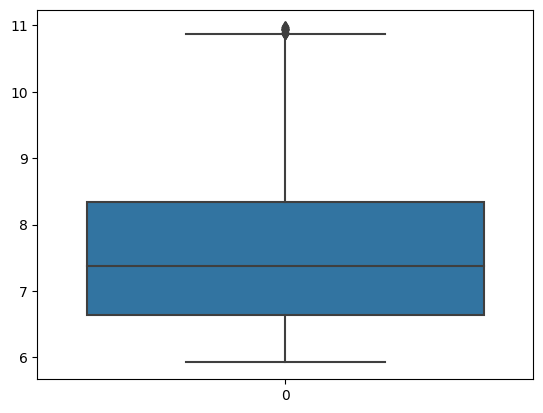

In [38]:
# average of the number of hours worked per day
in_time = in_time.dropna(axis=1, how='all')
out_time = out_time.dropna(axis=1, how='all')
in_time = in_time.dropna(axis=0, how='all')
out_time = out_time.dropna(axis=0, how='all')
in_time = in_time.apply(pd.to_datetime)
out_time = out_time.apply(pd.to_datetime)
hours_worked = out_time - in_time
hours_worked = hours_worked.applymap(lambda x: x.total_seconds() / 3600)
hours_worked = hours_worked.mean(axis=1)
hours_worked = hours_worked.dropna()
hours_worked = hours_worked.reset_index(drop=True)
sns.boxplot(hours_worked)



In [39]:
hours_worked_df = pd.DataFrame({
    "EmployeeID": general["EmployeeID"],
    "avg_hours_worked": hours_worked })
hours_worked_df

,EmployeeID,avg_hours_worked
0,1,7.342004
1,2,7.686399
2,3,6.984379
3,4,7.163197
4,5,7.973629
...,...,...
4405,4406,8.487350
4406,4407,6.067777
4407,4408,7.673414
4408,4409,9.453369


On remarque un taux plus élevé de démissions chez les gens qui travaillent le plus

<Axes: xlabel='avg_hours_worked', ylabel='Count'>

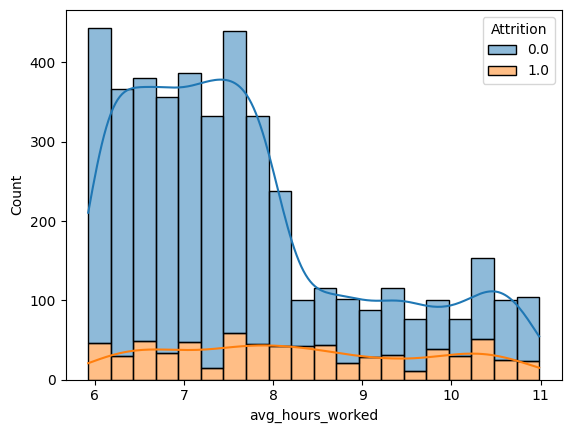

In [40]:
general_time = general.merge(hours_worked_df, on="EmployeeID")

sns.histplot(data=general_time, x="avg_hours_worked", hue="Attrition", multiple="stack", bins=20, kde=True)

In [41]:
general_badAll = general_time.merge(BadAll, on="EmployeeID", copy=True)

(general_badAll["Attrition"] == 0).sum()

133

In [42]:
out_timeAverage = out_time[out_time.columns[1:]].apply(pd.to_datetime)
out_timeAverage = out_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
out_timeAverage  = out_timeAverage.mean(axis=1)
out_timeAverage = out_timeAverage.to_frame()
out_timeAverage = out_timeAverage.assign(EmployeeID=range(1, len(out_timeAverage)+1))
out_timeAverage = out_timeAverage.rename(columns={0: 'avg_out_time'})

In [43]:
in_timeAverage = in_time[in_time.columns[1:]].apply(pd.to_datetime)
in_timeAverage = in_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
in_timeAverage = in_timeAverage.mean(axis=1)
in_timeAverage = in_timeAverage.to_frame()
in_timeAverage = in_timeAverage.assign(EmployeeID=range(1, len(in_timeAverage)+1))
in_timeAverage = in_timeAverage.rename(columns={0:'AverageStartTime'})

In [44]:
all_data = general.merge(manager_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(employee_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(hours_worked_df, on="EmployeeID", copy=True)
all_data = all_data.merge(out_timeAverage, on="EmployeeID", copy=True)
all_data = all_data.merge(in_timeAverage, on="EmployeeID", copy=True)

In [45]:
print(all_data["EmployeeID"].unique())
print(all_data["Over18"].unique())
print(all_data["StandardHours"].unique())

[   1    2    3 ... 4408 4409 4410]
[1.]
[8]


In [46]:
def dataCleaning(all_data, type):
    if type == 1:
        # drop useless columns
        all_data.drop("EmployeeID", axis=1, inplace=True)
        all_data.drop("Over18", axis=1, inplace=True)
        all_data.drop("EmployeeCount", axis=1, inplace=True)
        all_data.drop("StandardHours", axis=1, inplace=True)

    if type == 2:
        # drop unethical columns
        all_data.drop("Male", axis=1, inplace=True)
        all_data.drop("Female", axis=1, inplace=True)
        all_data.drop("Single", axis=1, inplace=True)
        all_data.drop("Married", axis=1, inplace=True)
        all_data.drop("Divorced", axis=1, inplace=True)
        all_data.drop("Age", axis=1, inplace=True)

    return all_data

all_data = dataCleaning(all_data,1)

<Axes: >

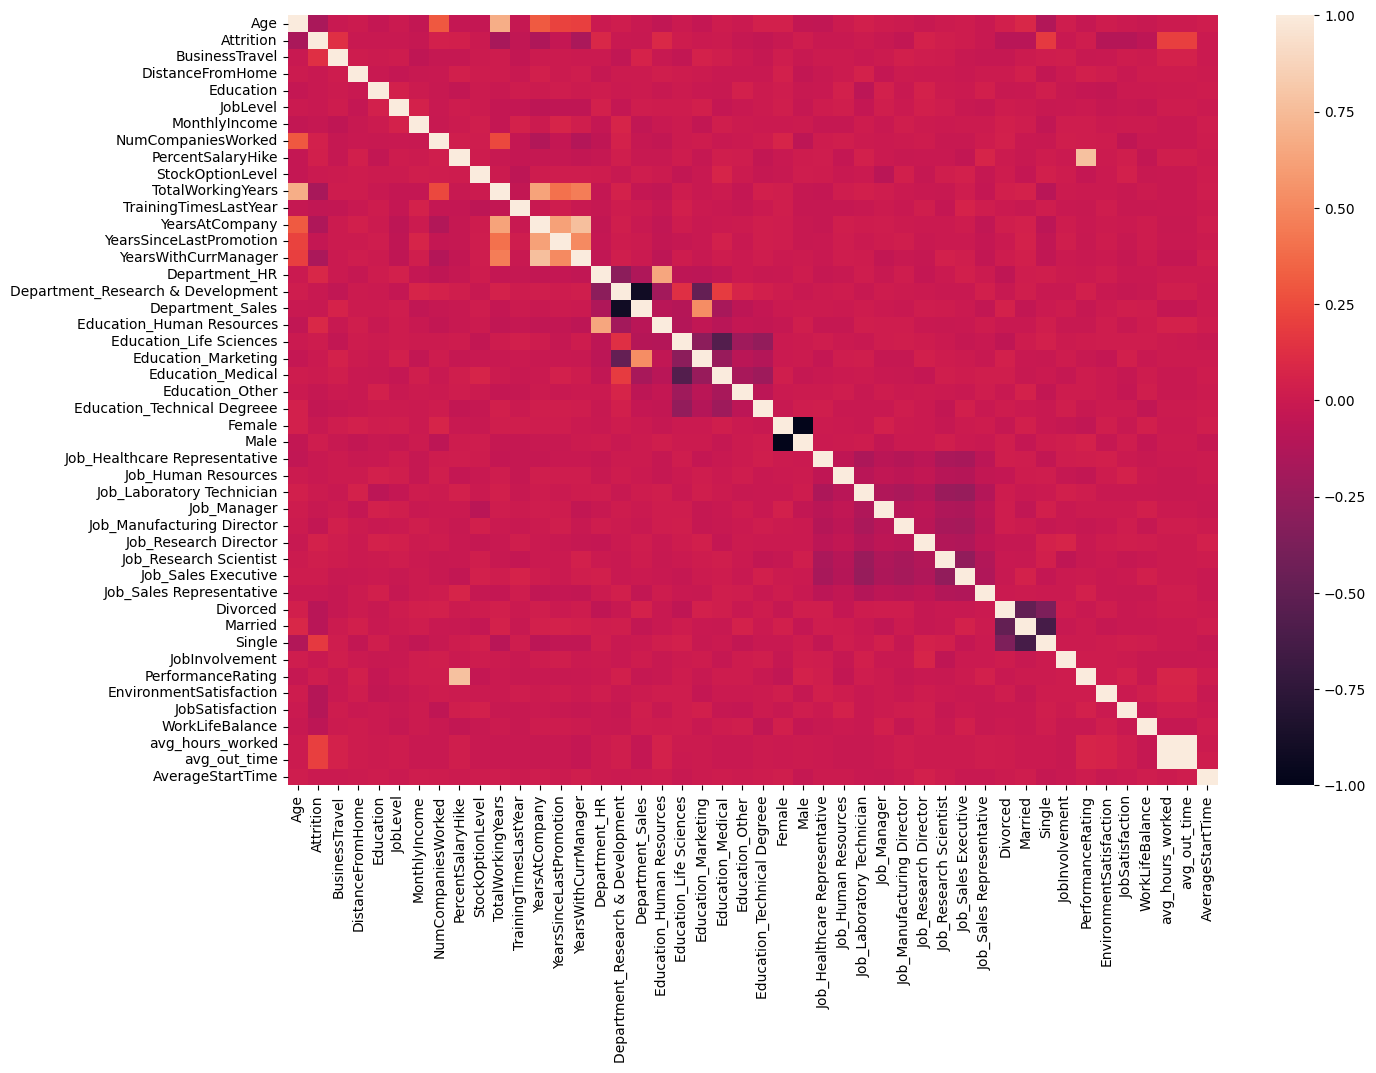

In [47]:
plt.figure(figsize=(15, 10))
sns.heatmap(all_data.corr(numeric_only=True))

<Axes: >

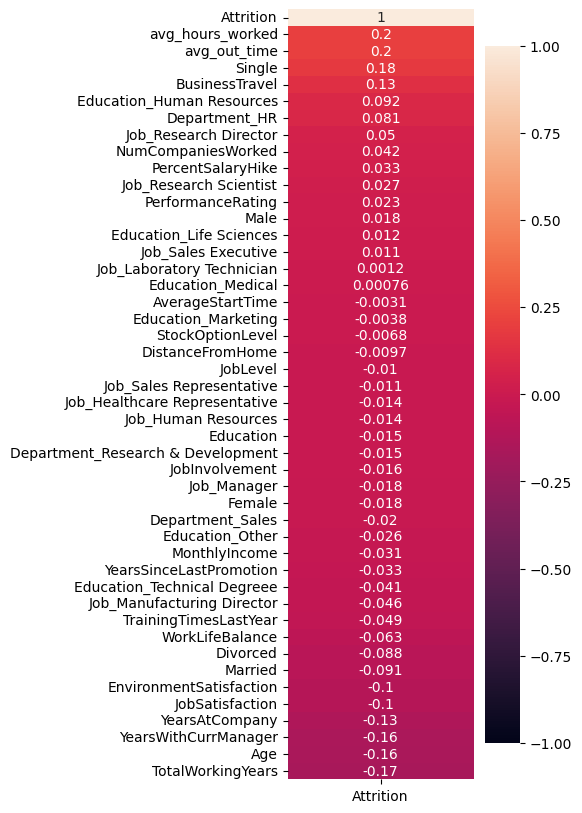

In [48]:
plt.figure(figsize=(3, 10))
all_data_corr = all_data.corr()
sns.heatmap(all_data_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True)

Lien entre age et temps travaillé

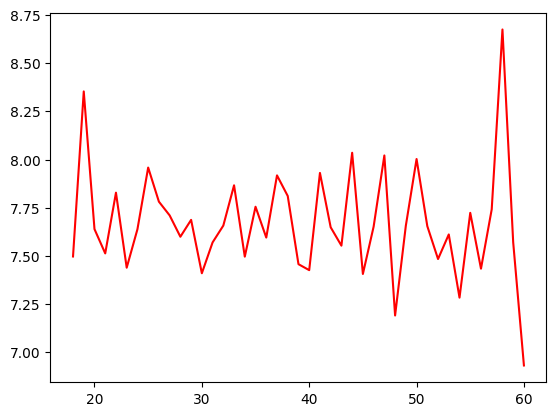

In [49]:
age_hours_worked = all_data.groupby(['Age'])["avg_hours_worked"].mean()
plt.plot(age_hours_worked.index, age_hours_worked.values, color="red")

In [50]:
all_data = dataCleaning(all_data,2)

# Gestion des valeurs manquantes

In [51]:
def nullToMedian(all_data):
    all_data["NumCompaniesWorked"] = all_data["NumCompaniesWorked"].replace(np.nan,median(all_data["NumCompaniesWorked"]))
    all_data["TotalWorkingYears"] = all_data["TotalWorkingYears"].replace(np.nan,median(all_data["TotalWorkingYears"]))

    all_data["EnvironmentSatisfaction"] = all_data["EnvironmentSatisfaction"].replace(np.nan,median(all_data["EnvironmentSatisfaction"]))
    all_data["JobSatisfaction"] = all_data["JobSatisfaction"].replace(np.nan,median(all_data["JobSatisfaction"]))
    all_data["WorkLifeBalance"] = all_data["WorkLifeBalance"].replace(np.nan,median(all_data["WorkLifeBalance"]))
    return all_data

def nullToKnnImputer(all_data):
    imputer = KNNImputer(n_neighbors=5)
    all_data_imputed = pd.DataFrame(imputer.fit_transform(all_data), columns=all_data.columns)
    return all_data_imputed

all_data = nullToMedian(all_data)

# Normalisation des données

In [52]:
min_max_scaler = lambda x: (x-x.min()) / (x.max()-x.min())
all_data = all_data.apply(min_max_scaler)
all_data

,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,Job_Sales Executive,Job_Sales Representative,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,avg_hours_worked,avg_out_time,AverageStartTime
0,0.0,0.5,0.178571,0.25,0.00,0.637546,0.111111,0.000000,0.000000,0.025,...,0.0,0.0,0.666667,0.0,0.666667,1.000000,0.333333,0.280179,0.278397,0.455440
1,1.0,1.0,0.321429,0.00,0.00,0.167457,0.000000,0.857143,0.333333,0.150,...,0.0,0.0,0.333333,1.0,0.666667,0.333333,1.000000,0.348247,0.343277,0.360231
2,0.0,1.0,0.571429,0.75,0.75,0.964666,0.111111,0.285714,1.000000,0.125,...,1.0,0.0,0.666667,0.0,0.333333,0.333333,0.000000,0.209497,0.212578,0.624032
3,0.0,0.0,0.035714,1.00,0.50,0.385045,0.333333,0.000000,1.000000,0.325,...,0.0,0.0,0.333333,0.0,1.000000,1.000000,0.666667,0.244839,0.239394,0.315702
4,0.0,0.5,0.321429,0.00,0.00,0.070195,0.444444,0.071429,0.666667,0.225,...,1.0,0.0,0.666667,0.0,1.000000,0.000000,0.666667,0.405016,0.401445,0.434548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.0,0.5,0.142857,0.75,0.00,0.264350,0.333333,0.428571,0.333333,0.250,...,0.0,0.0,0.666667,0.0,1.000000,0.000000,0.666667,0.506549,0.506475,0.586438
4406,0.0,0.5,0.035714,0.75,0.00,0.087941,0.222222,0.285714,0.000000,0.250,...,0.0,0.0,0.333333,0.0,1.000000,1.000000,0.666667,0.028336,0.028650,0.475596
4407,0.0,0.5,0.857143,0.25,0.25,0.141811,0.000000,0.642857,0.000000,0.125,...,1.0,0.0,0.666667,1.0,0.000000,0.666667,0.666667,0.345680,0.339283,0.302463
4408,0.0,0.5,0.607143,0.25,0.00,0.073144,0.000000,0.214286,0.333333,0.250,...,0.0,0.0,0.333333,0.0,1.000000,0.000000,0.666667,0.697477,0.695871,0.577572


# Mise en place des modèles

In [53]:
y = all_data["Attrition"]

X = all_data.drop(columns=["Attrition"])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [54]:
def score(model, x_train, y_train):
    print("Accuracy:", cross_val_score(model, x_train, y_train, cv=7, scoring='accuracy').mean())
    print("F1 score:", cross_val_score(model, x_train, y_train, cv=7, scoring='f1').mean())
    print("Precision:", cross_val_score(model, x_train, y_train, cv=7, scoring='precision').mean())
    print("Recall:", cross_val_score(model, x_train, y_train, cv=7, scoring='recall').mean())
    print("ROC AUC score:", cross_val_score(model, x_train, y_train, cv=7, scoring='roc_auc').mean())

    fig, ax = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax)
    plt.show()

## Choix des hyperparamètres

### DecisionTreeClassifier

Pour le DecisionTreeClassifier nous allons utiliser GridSearch afin de trouver les meilleurs hyperparamètres

In [55]:
pipeline_dtc = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

In [56]:
criterion = ['gini', 'entropy']
max_depth = [16,18,20,21,22,23,24]
splitter = ['best','random']


parameters_dtc = dict(classifier__criterion=criterion,
                  classifier__max_depth=max_depth,
                  classifier__splitter=splitter)


In [57]:
dtc_GS = GridSearchCV(pipeline_dtc, parameters_dtc, cv=7)
dtc_GS.fit(x_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [16, 18, 20, 21, 22, 23, 24],
                         'classifier__splitter': ['best', 'random']})

In [58]:
pd.DataFrame.from_dict(dtc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
19,0.011355,0.000870,0.002223,0.000455,entropy,20,random,"{'classifier__criterion': 'entropy', 'classifi...",0.977612,0.970149,0.986940,0.973832,0.990654,0.985047,0.971963,0.979457,0.007469,1
5,0.011384,0.000634,0.002508,0.000540,gini,20,random,"{'classifier__criterion': 'gini', 'classifier_...",0.972015,0.972015,0.979478,0.971963,0.979439,0.981308,0.983178,0.977056,0.004533,2
27,0.010967,0.000779,0.002077,0.000180,entropy,24,random,"{'classifier__criterion': 'entropy', 'classifi...",0.972015,0.981343,0.977612,0.962617,0.983178,0.983178,0.979439,0.977054,0.006899,3
17,0.011533,0.000606,0.001792,0.000352,entropy,18,random,"{'classifier__criterion': 'entropy', 'classifi...",0.945896,0.975746,0.981343,0.966355,0.996262,0.975701,0.990654,0.975994,0.015368,4
11,0.011064,0.000682,0.001865,0.000219,gini,23,random,"{'classifier__criterion': 'gini', 'classifier_...",0.972015,0.973881,0.983209,0.966355,0.985047,0.971963,0.979439,0.975987,0.006272,5


Accuracy: 0.9719945001295259
F1 score: 0.9234482725958529
Precision: 0.9006473409974527
Recall: 0.9254973841982662
ROC AUC score: 0.9640530212021702


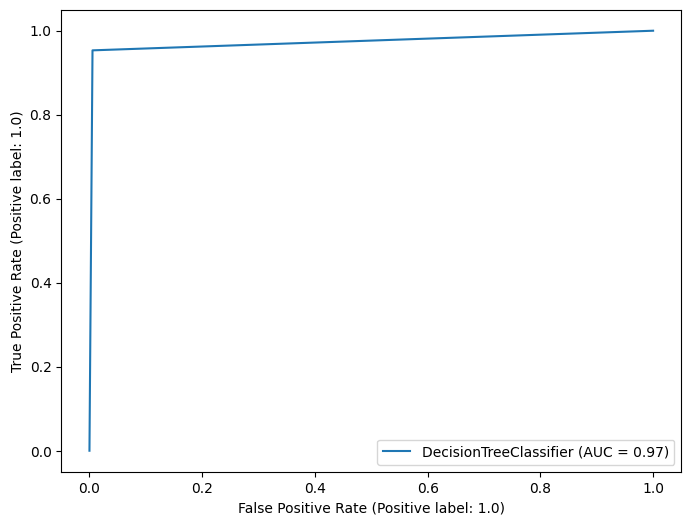

In [59]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20, splitter="random")

dtc.fit(x_train, y_train)

score(dtc, x_train, y_train)

Après plusieurs tests, on ressort qu'une max_depth de 22 et un criterion en entropy est le meilleur model que l'on peu avoir

In [60]:
y_pred_dtc = dtc.predict(x_test)

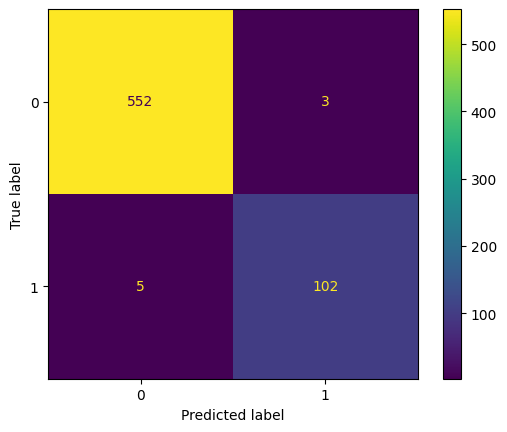

In [61]:
dtc_cm = confusion_matrix(y_test, y_pred_dtc)
dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm,
                       display_labels=[0,1])

dtc_cmd.plot()
plt.show()


### HistGradientBoostingClassifier

In [62]:
pipeline_hgbc = Pipeline(steps=[
    ('classifier', HistGradientBoostingClassifier())
])

In [63]:
learning_rate = [0.1,0.2]
max_depth = [10,15,20]
loss = ['log_loss']
max_iter = [10,20,50,100]

parameters_hgbc = dict(classifier__learning_rate=learning_rate,
                  classifier__max_depth=max_depth,
                  classifier__loss=loss,
                  classifier__max_iter=max_iter
                  )

In [64]:
hgbc_GS = GridSearchCV(pipeline_hgbc, parameters_hgbc)
hgbc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.2],
                         'classifier__loss': ['log_loss'],
                         'classifier__max_depth': [10, 15, 20],
                         'classifier__max_iter': [10, 20, 50, 100]})

In [65]:
pd.DataFrame.from_dict(hgbc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_depth,param_classifier__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,1.358727,0.006965,0.008018,0.000999,0.2,log_loss,10,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.981333,0.989333,0.986667,0.990654,0.981308,0.985859,0.003922,1
19,1.408688,0.019470,0.007422,0.000671,0.2,log_loss,15,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.976000,0.984000,0.988000,0.987984,0.987984,0.984794,0.004660,2
23,1.425776,0.041975,0.007220,0.000248,0.2,log_loss,20,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.970667,0.985333,0.984000,0.991989,0.990654,0.984529,0.007567,3
11,1.409040,0.009829,0.007423,0.000667,0.1,log_loss,20,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.976000,0.976000,0.980000,0.983979,0.985314,0.980258,0.003892,4
14,0.863483,0.212696,0.004609,0.000588,0.2,log_loss,10,50,"{'classifier__learning_rate': 0.2, 'classifier...",0.973333,0.977333,0.980000,0.986649,0.981308,0.979725,0.004407,5


Accuracy: 0.9903981427973619
F1 score: 0.9692612185172222
Precision: 0.9895945583400116
Recall: 0.9503952342765494
ROC AUC score: 0.9907863720385354


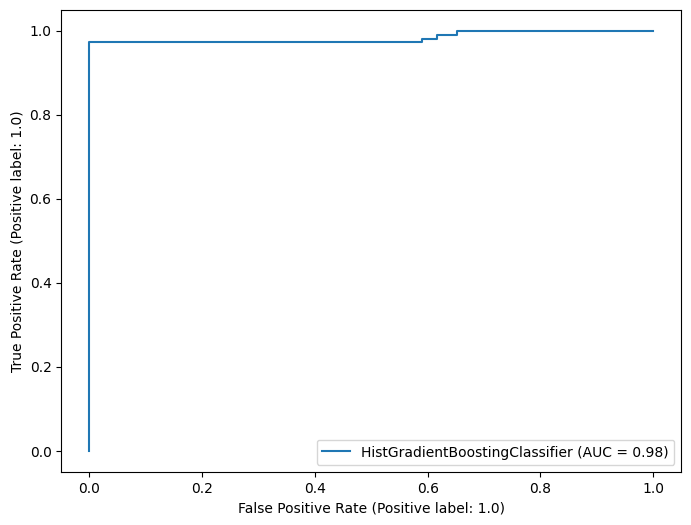

In [66]:
hgbc = HistGradientBoostingClassifier(learning_rate=0.2, max_depth=20, max_iter=100, loss="log_loss")

hgbc.fit(x_train, y_train)

score(hgbc, x_train, y_train)

In [67]:
y_pred_hgbc = hgbc.predict(x_test)

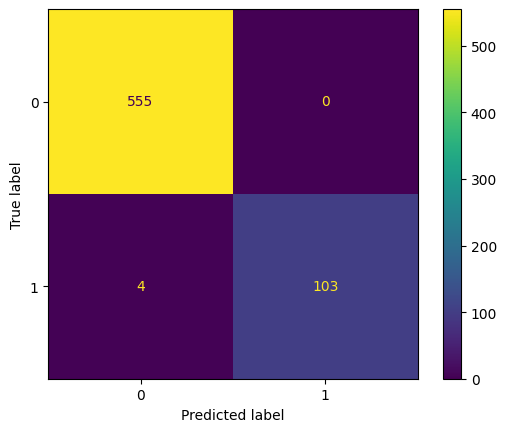

In [68]:
cm_hgbc = confusion_matrix(y_test, y_pred_hgbc)
cmd_hgbc = ConfusionMatrixDisplay(confusion_matrix=cm_hgbc,
                       display_labels=[0,1])

cmd_hgbc.plot()
plt.show()

### RandomForestClassifier

In [103]:
pipeline_rfc = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

In [104]:
n_estimators = [1,2,3,5,10,50,100,200,300]
criterion = ['gini', 'entropy']
max_depth = [5,10,14,18,22,24,30,50,100]


parameters_rfc = dict(classifier__n_estimators=n_estimators,
                  classifier__criterion=criterion,
                  classifier__max_depth=max_depth
                  )

In [71]:
rfc_GS = GridSearchCV(pipeline_rfc, parameters_rfc)
rfc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [5, 10, 14, 18, 22, 24, 30,
                                                   50, 100],
                         'classifier__n_estimators': [1, 2, 3, 5, 10, 50, 100,
                                                      200, 300]})

In [72]:
pd.DataFrame.from_dict(rfc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
124,1.222527,0.013251,0.034187,0.000427,entropy,22,200,"{'classifier__criterion': 'entropy', 'classifi...",0.969333,0.976000,0.981333,0.987984,0.979973,0.978925,0.006157,1
43,1.114399,0.017703,0.037462,0.002634,gini,22,200,"{'classifier__criterion': 'gini', 'classifier_...",0.969333,0.973333,0.980000,0.986649,0.981308,0.978125,0.006108,2
161,1.830498,0.021685,0.052280,0.001618,entropy,100,300,"{'classifier__criterion': 'entropy', 'classifi...",0.972000,0.972000,0.981333,0.989319,0.975968,0.978124,0.006562,3
125,1.851014,0.020157,0.050936,0.000766,entropy,22,300,"{'classifier__criterion': 'entropy', 'classifi...",0.970667,0.974667,0.977333,0.986649,0.979973,0.977858,0.005365,4
70,1.117935,0.022186,0.037735,0.001979,gini,50,200,"{'classifier__criterion': 'gini', 'classifier_...",0.972000,0.973333,0.978667,0.986649,0.978638,0.977857,0.005164,5


Accuracy: 0.9871953649642309
F1 score: 0.9520318977727941
Precision: 0.9961904761904762
Recall: 0.9172108298010463
ROC AUC score: 0.9952992125421726


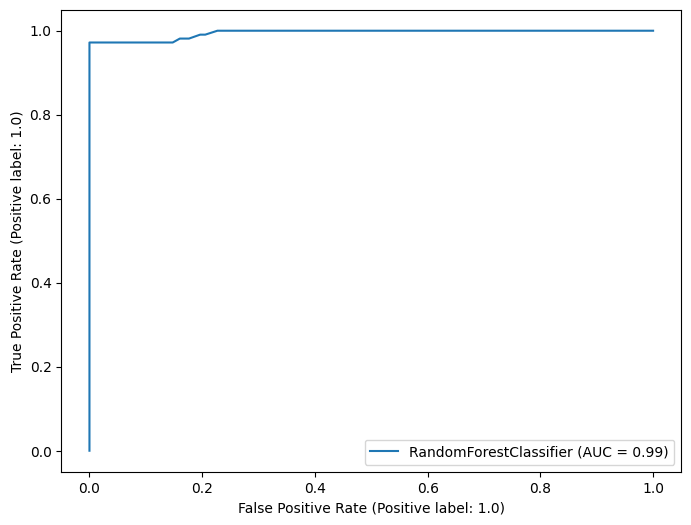

In [105]:
rfc = RandomForestClassifier(n_estimators=300,criterion='entropy',max_depth=24)

rfc.fit(x_train, y_train)

score(rfc, x_train, y_train)

In [74]:
y_pred_rfc = rfc.predict(x_test)

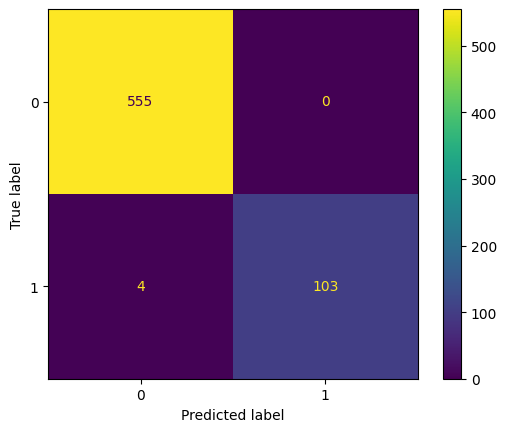

In [75]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cmd_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                       display_labels=[0,1])

cmd_rfc.plot()
plt.show()

### Perceptron

In [76]:
pipeline_pe = Pipeline(steps=[
    ('classifier', Perceptron())
])

In [77]:
penalty = ['l2','l1','elasticnet']
alpha = [0.0001,0.0002,0.0003]


parameters_pe = dict(classifier__penalty=penalty,
                  classifier__alpha=alpha)


In [78]:
pe_GS = GridSearchCV(pipeline_pe, parameters_pe)
pe_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', Perceptron())]),
             param_grid={'classifier__alpha': [0.0001, 0.0002, 0.0003],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet']})

In [79]:
pd.DataFrame.from_dict(pe_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.023906,0.003791,0.001904,0.000198,0.0002,elasticnet,"{'classifier__alpha': 0.0002, 'classifier__pen...",0.838667,0.832000,0.838667,0.841121,0.847797,0.839650,0.005079,1
8,0.021776,0.003761,0.002105,0.000204,0.0003,elasticnet,"{'classifier__alpha': 0.0003, 'classifier__pen...",0.834667,0.856000,0.840000,0.831776,0.826435,0.837776,0.010113,2
0,0.006464,0.000852,0.002504,0.000446,0.0001,l2,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.836000,0.828000,0.837333,0.835781,0.835781,0.834579,0.003340,3
6,0.006057,0.000591,0.001803,0.000404,0.0003,l2,"{'classifier__alpha': 0.0003, 'classifier__pen...",0.833333,0.809333,0.808000,0.845127,0.825100,0.824179,0.014182,4
7,0.012075,0.001215,0.002113,0.000152,0.0003,l1,"{'classifier__alpha': 0.0003, 'classifier__pen...",0.788000,0.828000,0.838667,0.801068,0.835781,0.818303,0.020147,5


Accuracy: 0.8028266544447324
F1 score: 0.3053964650670827
Precision: 0.39305700165405105
Recall: 0.31605376713636535
ROC AUC score: 0.7333380818882773


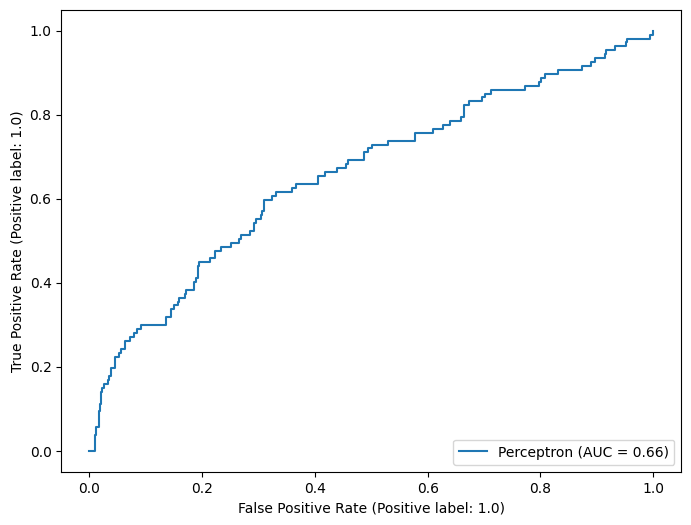

In [80]:
pe = Perceptron(penalty='l2',alpha = 0.0001)

pe.fit(x_train, y_train)

score(pe, x_train, y_train)

In [81]:
y_pred_pe = pe.predict(x_test)

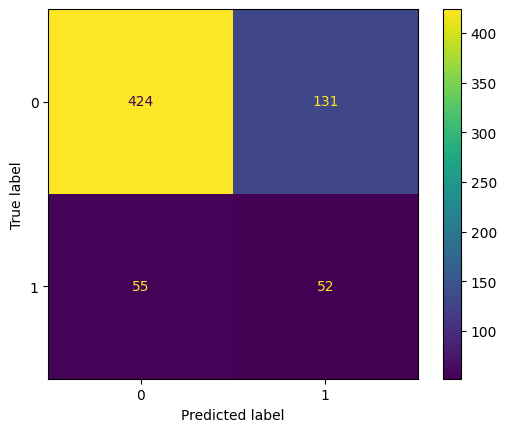

In [82]:
cm_pe = confusion_matrix(y_test, y_pred_pe)
cmd_pe = ConfusionMatrixDisplay(confusion_matrix=cm_pe,
                       display_labels=[0,1])

cmd_pe.plot()
plt.show()

### Logistic Regression

In [83]:
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

In [84]:
penalty = ['l2']
max_iter = [100,500,1000]


parameters_lr = dict(classifier__penalty = penalty,
                  classifier__max_iter = max_iter)

In [85]:
lr_GS = GridSearchCV(pipeline_lr, parameters_lr)
lr_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier__max_iter': [100, 500, 1000],
                         'classifier__penalty': ['l2']})

In [86]:
pd.DataFrame.from_dict(lr_GS.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040728,0.003112,0.001802,0.000400,100,l2,"{'classifier__max_iter': 100, 'classifier__pen...",0.848,0.856,0.848,0.853138,0.871829,0.855393,0.008774,1
1,0.038984,0.002884,0.002016,0.000029,500,l2,"{'classifier__max_iter': 500, 'classifier__pen...",0.848,0.856,0.848,0.853138,0.871829,0.855393,0.008774,1
2,0.038251,0.003463,0.002100,0.000205,1000,l2,"{'classifier__max_iter': 1000, 'classifier__pe...",0.848,0.856,0.848,0.853138,0.871829,0.855393,0.008774,1


Accuracy: 0.8548597134487775
F1 score: 0.2970161433609043
Precision: 0.6602728388615907
Recall: 0.19368388895253372
ROC AUC score: 0.7921596773749557


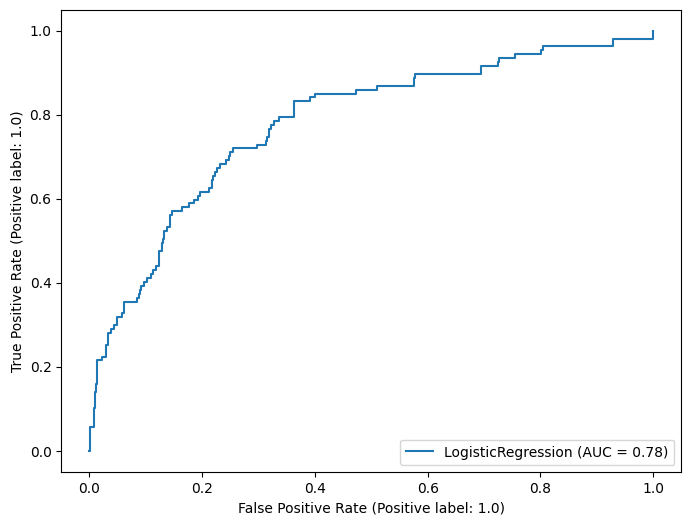

In [87]:
lr = LogisticRegression(penalty='l2', max_iter = 100)

lr.fit(x_train, y_train)

score(lr, x_train, y_train)

In [88]:
y_pred_lr = lr.predict(x_test)

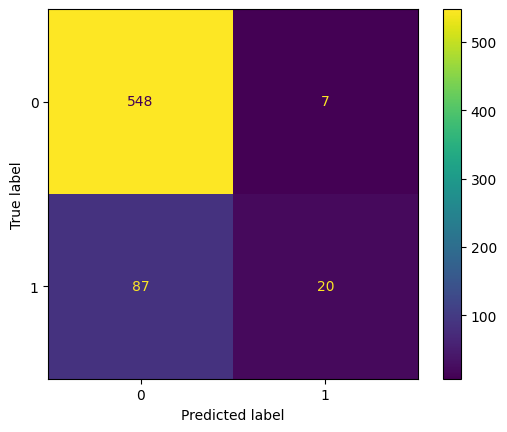

In [89]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cmd_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                       display_labels=[0,1])

cmd_lr.plot()
plt.show()

# Analyse des résultats

### DecisionTreeClassifier

In [90]:
cl_dtc = list(zip(x_train.columns, dtc.feature_importances_))
coefs_dtc = pd.DataFrame(cl_dtc, columns = ['Column', 'Coefs'])
coefs_dtc.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
8,TotalWorkingYears,0.085516
36,avg_hours_worked,0.076848
10,YearsAtCompany,0.055566
33,EnvironmentSatisfaction,0.053062
0,BusinessTravel,0.052182
37,avg_out_time,0.046049
3,JobLevel,0.038990
4,MonthlyIncome,0.038161
17,Education_Life Sciences,0.037907
12,YearsWithCurrManager,0.035240


### HistGradientBoostingClassifier

In [112]:
hgbc.n_trees_per_iteration_

1

### RandomForestClassifier

In [109]:
cl_rfc = list(zip(x_train.columns, rfc.feature_importances_))
coefs_rfc= pd.DataFrame(cl_rfc, columns = ['Column', 'Coefs'])
coefs_rfc.sort_values(by=['Coefs'], ascending=False)


,Column,Coefs
36,avg_hours_worked,0.087359
37,avg_out_time,0.086667
8,TotalWorkingYears,0.081539
4,MonthlyIncome,0.066704
10,YearsAtCompany,0.055004
1,DistanceFromHome,0.051174
12,YearsWithCurrManager,0.046106
6,PercentSalaryHike,0.044263
5,NumCompaniesWorked,0.041414
33,EnvironmentSatisfaction,0.037519


### Perceptron

In [91]:
cl_pe = list(zip(x_train.columns, pe.coef_[0]))
coefs_pe = pd.DataFrame(cl_pe, columns = ['Column', 'Coefs'])
coefs_pe.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
24,Job_Laboratory Technician,4.613918
16,Education_Human Resources,4.400000
11,YearsSinceLastPromotion,3.656659
29,Job_Sales Executive,3.637282
36,avg_hours_worked,3.502308
5,NumCompaniesWorked,3.414979
37,avg_out_time,3.396438
0,BusinessTravel,3.092403
35,WorkLifeBalance,2.432527
13,Department_HR,1.945444


### LogisticRegression

In [92]:
cl_lr = list(zip(x_train.columns, lr.coef_[0]))
coefs_lr = pd.DataFrame(cl_lr, columns = ['Column', 'Coefs'])
coefs_lr.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
11,YearsSinceLastPromotion,1.943983
0,BusinessTravel,1.455804
36,avg_hours_worked,1.094677
37,avg_out_time,1.084080
5,NumCompaniesWorked,0.901343
16,Education_Human Resources,0.646746
27,Job_Research Director,0.545875
13,Department_HR,0.341068
29,Job_Sales Executive,0.313335
6,PercentSalaryHike,0.291176


# Conclusion
<div id="cc"></div>

On remarque que l'étude sur le fait de se sentir bien ou non a un fort impact sur les démissions
On remarque aussi que le nombre d'heure travaillée a aussi un certain impacte sur les démissions